In [15]:
# Backtest Crossover 50-200 (Notebook)
# เซลล์นี้โหลดไลบรารีและสร้าง SQLAlchemy engine

import os
from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np

# โหลดตัวแปรจาก .env
load_dotenv()  # ควรมี DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
TABLE_NAME = "sp500_prices"  # เปลี่ยนถ้าตารางชื่ออื่น

if not all([DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME]):
    raise RuntimeError("กรุณาตั้งค่า environment variables (DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME)")

DB_URI = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DB_URI)


In [16]:
# สร้าง connection string
db_uri = (
    f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}"
    f"@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
)

# สร้าง engine
engine = create_engine(db_uri)

In [17]:

# ดึงข้อมูลจาก table
query = "SELECT date, \"Close\" FROM sp500_prices ORDER BY date"
df = pd.read_sql(query, con=engine)

# แปลง column date เป็น datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [18]:
df.head()


,date,Close
0,1927-12-30,17.660000
1,1928-01-03,17.760000
2,1928-01-04,17.719999
3,1928-01-05,17.549999
4,1928-01-06,17.660000


In [19]:
# SMA
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA200'] = df['Close'].rolling(window=200).mean()

# Signal
df['Signal'] = 0
df.loc[df['SMA50'] > df['SMA200'], 'Signal'] = 1

df[['date','Close','SMA50','SMA200','Signal']].tail(10)

,date,Close,SMA50,SMA200,Signal
24549,2025-09-25,6604.720215,6452.842783,6012.145891,1
24550,2025-09-26,6643.700195,6459.769590,6014.913042,1
24551,2025-09-29,6661.209961,6467.057988,6017.954841,1
24552,2025-09-30,6688.459961,6474.715186,6021.222590,1
24553,2025-10-01,6711.200195,6482.746787,6024.357642,1
24554,2025-10-02,6715.350098,6489.875586,6027.678142,1
24555,2025-10-03,6715.790039,6496.924385,6031.001643,1
24556,2025-10-06,6740.279785,6503.957178,6034.332642,1
24557,2025-10-07,6714.589844,6510.453574,6037.652542,1
24558,2025-10-08,6721.859863,6517.473574,6041.901040,1


In [20]:
# Daily return
df['Daily_Return'] = df['Close'].pct_change()

# Strategy return ใช้ signal ของวันก่อนหน้า
df['Strategy_Return'] = df['Daily_Return'] * df['Signal'].shift(1)

# Cumulative return
df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod() - 1
df['Cumulative_BuyHold'] = (1 + df['Daily_Return']).cumprod() - 1

df[['date','Close','Signal','Daily_Return','Strategy_Return','Cumulative_Strategy','Cumulative_BuyHold']].tail(10)


,date,Close,Signal,Daily_Return,Strategy_Return,Cumulative_Strategy,Cumulative_BuyHold
24549,2025-09-25,6604.720215,1,-0.005009,-0.005009,391.599732,372.993220
24550,2025-09-26,6643.700195,1,0.005902,0.005902,393.916791,375.200467
24551,2025-09-29,6661.209961,1,0.002636,0.002636,394.957612,376.191960
24552,2025-09-30,6688.459961,1,0.004091,0.004091,396.577415,377.734995
24553,2025-10-01,6711.200195,1,0.003400,0.003400,397.929146,379.022664
24554,2025-10-02,6715.350098,1,0.000618,0.000618,398.175826,379.257653
24555,2025-10-03,6715.790039,1,0.000066,0.000066,398.201977,379.282565
24556,2025-10-06,6740.279785,1,0.003647,0.003647,399.657704,380.669300
24557,2025-10-07,6714.589844,1,-0.003811,-0.003811,398.130635,379.214604
24558,2025-10-08,6721.859863,1,0.001083,0.001083,398.562781,379.626270


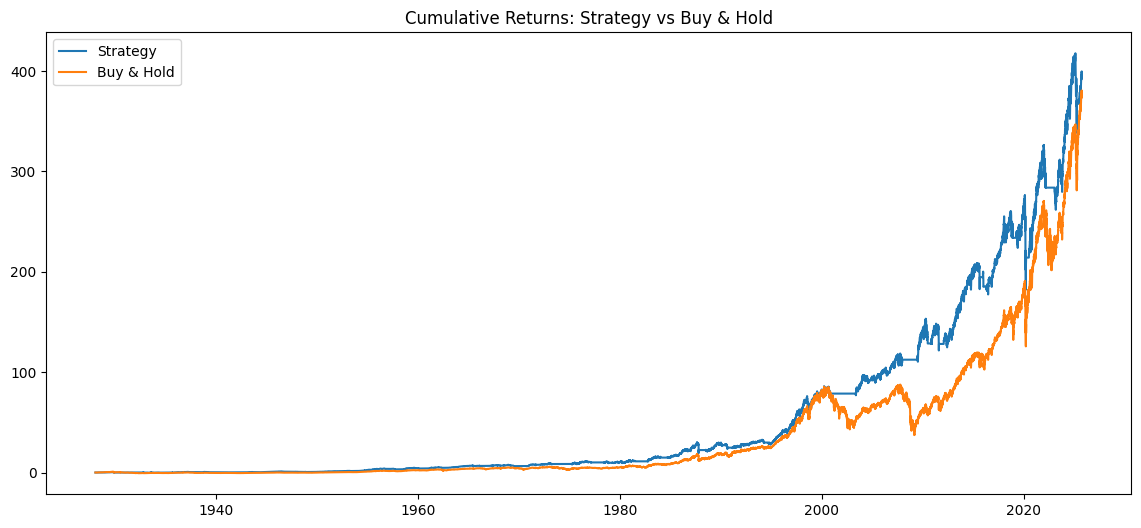

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['date'], df['Cumulative_Strategy'], label='Strategy')
plt.plot(df['date'], df['Cumulative_BuyHold'], label='Buy & Hold')
plt.legend()
plt.title('Cumulative Returns: Strategy vs Buy & Hold')
plt.show()
